In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from astropy.io import fits, ascii
from astropy.table import Table
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os
import math
from natsort import natsorted as nsort

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

In [4]:
dfile = AP_PATH + '/training_sets/mann_sample_89/'
rfile = '../train_ref/mann_combined_ref_labels_89.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('2-')[1].split('.fits')[0] for x in ids])
tr_label = ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H'])
# tr_label = ap.scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

wave = ap.rvShift(wl, rv=-80)
ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
ds.set_label_names(['T_{eff}', '[Fe/H]'])
ds.tr_label.shape, ds.tr_ID.shape, ds.tr_flux.shape, ds.tr_ivar.shape

bands = [[15140,15800],[15860,16425],[16475,16945]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/data/apogee_data/training_sets/mann_sample_89/
Spectra loaded


In [5]:
md, ds, synth = ap.fitCannonModel(ds)
np.save('cross_validation/model_coeff_fullset', md.coeffs)

Done training model. 
Inferring Labels


In [87]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


In [92]:
trn_labels, tst_labels, crv_labels = ap.crossValidate(ds, save_dir='cross_validation/')

Done training model. 
Inferring Labels
Done training model. 
Inferring Labels
Inferring Labels
Labeled [1/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [2/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [3/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [4/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [5/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [6/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [7/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [8/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [9/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [10/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [11/89] sources.

Done training model. 
Inferring Labels
Inferring Labels
Labeled [12/

In [6]:
# np.save('cross_validation/trn_labels', trn_labels)
# np.save('cross_validation/tst_labels', tst_labels)
# np.save('cross_validation/crv_labels', crv_labels)

trn_labels = np.load('cross_validation/trn_labels.npy')
tst_labels = np.load('cross_validation/tst_labels.npy')
crv_labels = np.load('cross_validation/crv_labels.npy')

In [7]:
trn_teff = np.array(trn_labels).T[0]
trn_fe_h = np.array(trn_labels).T[1]
tst_teff = np.array(tst_labels).T[0]
tst_fe_h = np.array(tst_labels).T[1]
crv_teff = np.array(crv_labels).T[0]
crv_fe_h = np.array(crv_labels).T[1]

tst_teff_err = trn_teff - tst_teff 
crv_teff_err = trn_teff - crv_teff 
tst_fe_h_err = trn_fe_h - tst_fe_h
crv_fe_h_err = trn_fe_h - crv_fe_h 
teff_tst_crv_diff = tst_teff - crv_teff
fe_h_tst_crv_diff = tst_fe_h - crv_fe_h

def chi_sq(data, model, ivar):
    chi = []
    for i in range(len(data)):
        chi.append(np.sum(ivar[i]*(data[i]-model[i])**2))
    return np.array(chi)
chi = chi_sq(ds.tr_flux, synth, ds.tr_ivar)

crv_files = nsort(os.listdir('cross_validation/crv_flux/'))
crv_fls = np.array([np.load('cross_validation/crv_flux/' + f) for f in crv_files])
crv_chi = chi = chi_sq(ds.tr_flux, crv_fls, ds.tr_ivar)

In [8]:
# d = {'ID':tr_ID, 'SOURCE':pd.read_csv(rfile)['SOURCE'], 'TRAIN_TEFF':trn_teff, 'TEST_TEFF':tst_teff, 'CROSS_TEFF':crv_teff, \
#      'TEST_TEFF_ERR':tst_teff_err, 'CROSS_TEFF_ERR':crv_teff_err, \
#      'TEST_CROSS_DIFF_TEFF':teff_tst_crv_diff, \
#      'TRAIN_FEH':trn_fe_h, 'TEST_FEH':tst_fe_h, 'CROSS_FEH':crv_fe_h, \
#      'TEST_FEH_ERR':tst_teff_err, 'CROSS_FEH_ERR':crv_teff_err, \
#      'TEST_CROSS_DIFF_FEH':fe_h_tst_crv_diff}

rcont = pd.read_csv(rfile)
conv_index = np.array([np.where(rcont['ID'] == s)[0][0] for s in ds.tr_ID])
ra_ordered = rcont['RA'][conv_index]
dec_ordered = rcont['DEC'][conv_index]

d = {'ID':tr_ID, 'RA':np.round(ra_ordered, 5), 'DEC':np.round(dec_ordered, 5), \
     'TRAIN_TEFF':[int(x) for x in np.round(trn_teff)], 'TEST_TEFF':[int(x) for x in np.round(tst_teff)], 'CROSS_TEFF':[int(x) for x in np.round(crv_teff)], \
     'TRAIN_FEH':np.round(trn_fe_h, 2), 'TEST_FEH':np.round(tst_fe_h, 2), 'CROSS_FEH':np.round(crv_fe_h, 2), \
     'CHI_SQ':chi}

df = pd.DataFrame(data=OrderedDict(d))
df.to_csv('results/test_results.csv', index=None)

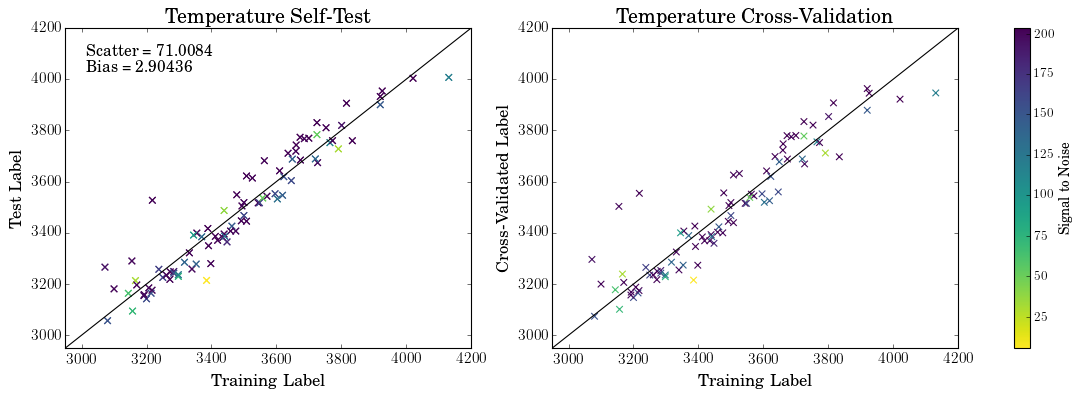

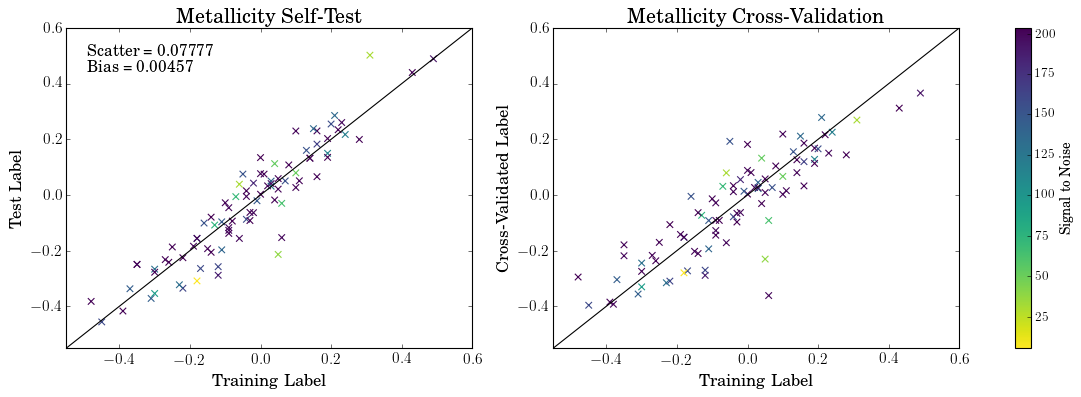

In [96]:
x = np.arange(-1,4300)

scat1, bias1 = np.round(np.std(tst_teff_err),5), np.round(np.mean(tst_teff_err),5)
scat2, bias2 = np.round(np.std(tst_fe_h_err),5), np.round(np.mean(tst_fe_h_err),5)
text1 = 'Scatter = %s \n Bias = %s'%(scat1, bias1)
text2 = 'Scatter = %s \n Bias = %s'%(scat2, bias2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_teff, tst_teff, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')

ax1.scatter(trn_teff, tst_teff, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(2950,4200)
ax1.set_ylim(2950,4200)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Temperature Self-Test', fontsize=18)

ax2.scatter(trn_teff, crv_teff, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax2.plot(x,x, color='k')
ax2.set_xlim(2950,4200)
ax2.set_ylim(2950,4200)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('Temperature Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label('Signal to Noise', fontsize=12)
plt.savefig('results/self_and_validation_test_teff_snr.png')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_teff, tst_teff, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')

ax1.scatter(trn_fe_h, tst_fe_h, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax1.text(0.05, 0.95, text2, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(-.55,.6)
ax1.set_ylim(-.55,.6)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Metallicity Self-Test', fontsize=18)

ax2.scatter(trn_fe_h, crv_fe_h, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax2.plot(x,x, color='k')
ax2.set_xlim(-.55,.6)
ax2.set_ylim(-.55,.6)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('Metallicity Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label('Signal to Noise', fontsize=12)
plt.savefig('results/self_and_validation_test_fe_h_snr.png')
plt.show()

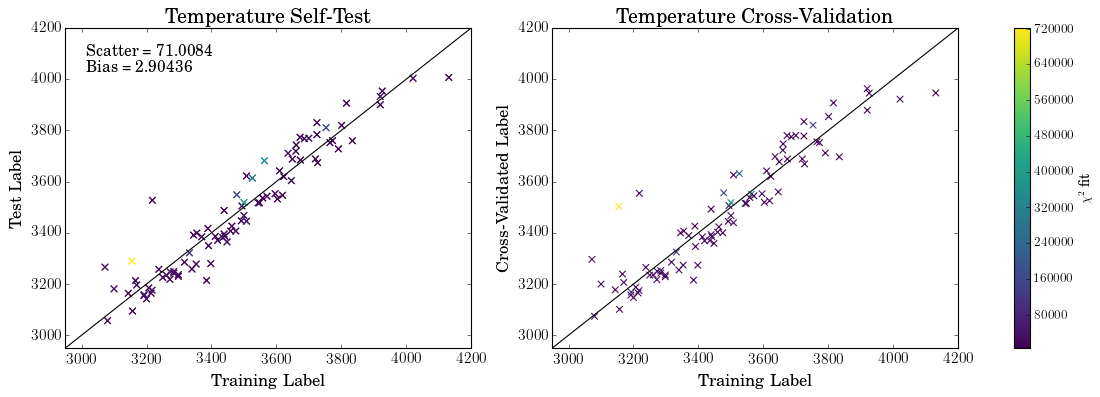

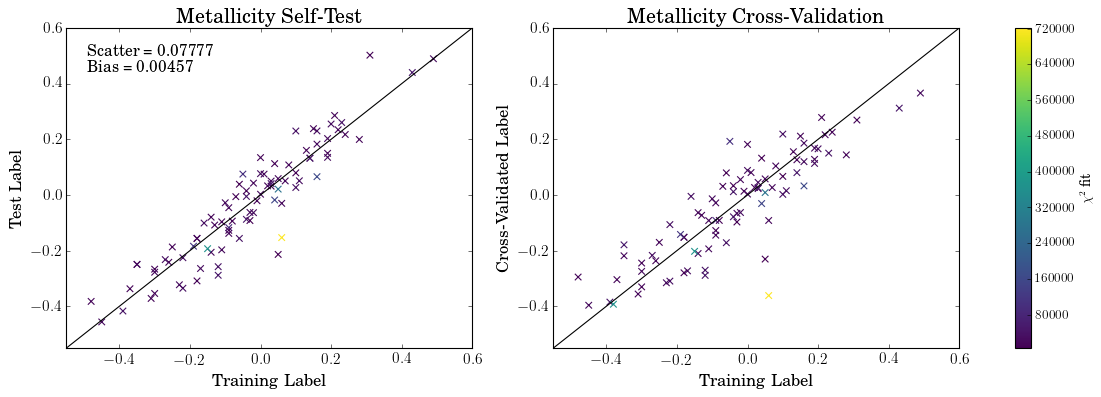

In [37]:
x = np.arange(-1,4300)

scat1, bias1 = np.round(np.std(tst_teff_err),5), np.round(np.mean(tst_teff_err),5)
scat2, bias2 = np.round(np.std(tst_fe_h_err),5), np.round(np.mean(tst_fe_h_err),5)
text1 = 'Scatter = %s \n Bias = %s'%(scat1, bias1)
text2 = 'Scatter = %s \n Bias = %s'%(scat2, bias2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_teff, tst_teff, marker='x', c=chi, s=35, cmap='viridis')

ax1.scatter(trn_teff, tst_teff, c=chi, marker='x', s=35, cmap='viridis')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(2950,4200)
ax1.set_ylim(2950,4200)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Temperature Self-Test', fontsize=18)

ax2.scatter(trn_teff, crv_teff, c=crv_chi, marker='x', s=35, cmap='viridis')
ax2.plot(x,x, color='k')
ax2.set_xlim(2950,4200)
ax2.set_ylim(2950,4200)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('Temperature Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label(r'$\chi^2$ fit', fontsize=12)
plt.savefig('results/self_and_validation_test_teff_chisq.png')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
pl = ax1.scatter(trn_teff, tst_teff, marker='x', c=chi, s=35, cmap='viridis')

ax1.scatter(trn_fe_h, tst_fe_h, c=chi, marker='x', s=35, cmap='viridis')
ax1.text(0.05, 0.95, text2, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.plot(x,x, color='k')
ax1.set_xlim(-.55,.6)
ax1.set_ylim(-.55,.6)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Metallicity Self-Test', fontsize=18)

ax2.scatter(trn_fe_h, crv_fe_h, c=crv_chi, marker='x', s=35, cmap='viridis')
ax2.plot(x,x, color='k')
ax2.set_xlim(-.55,.6)
ax2.set_ylim(-.55,.6)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_ylabel('Cross-Validated Label', fontsize=15)
ax2.set_title('Metallicity Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label(r'$\chi^2$ fit', fontsize=12)
plt.savefig('results/self_and_validation_test_fe_h_chisq.png')
plt.show()

In [29]:
np.where(chi > 6*10**5), np.where(crv_chi > 6*10**5), ds.tr_ID[12]

((array([12]),), (array([12]),), '2M05030563+2122362')

In [42]:
N = tr_label.shape[0]
coeff_n = np.array([np.load('cross_validation/model_coeff/model_coeff_'+str(i)+'.npy') for i in range(N)])
coeff_full = np.load('cross_validation/model_coeff_fullset.npy')

def jackknife(l,m):
    
    diff_sq = 0
    for n in range(N): #star
        diff_sq += (coeff_n[n][m][l] - coeff_full[m][l])**2
    
    s = (N-1)/N * diff_sq 
    
    return math.sqrt(s)

npix = len(ds.wl)
jack_err_teff = np.array([jackknife(3,m) for m in range(npix)])
jack_err_fe_h = np.array([jackknife(4,m) for m in range(npix)])

## Demo plots and derivatives:

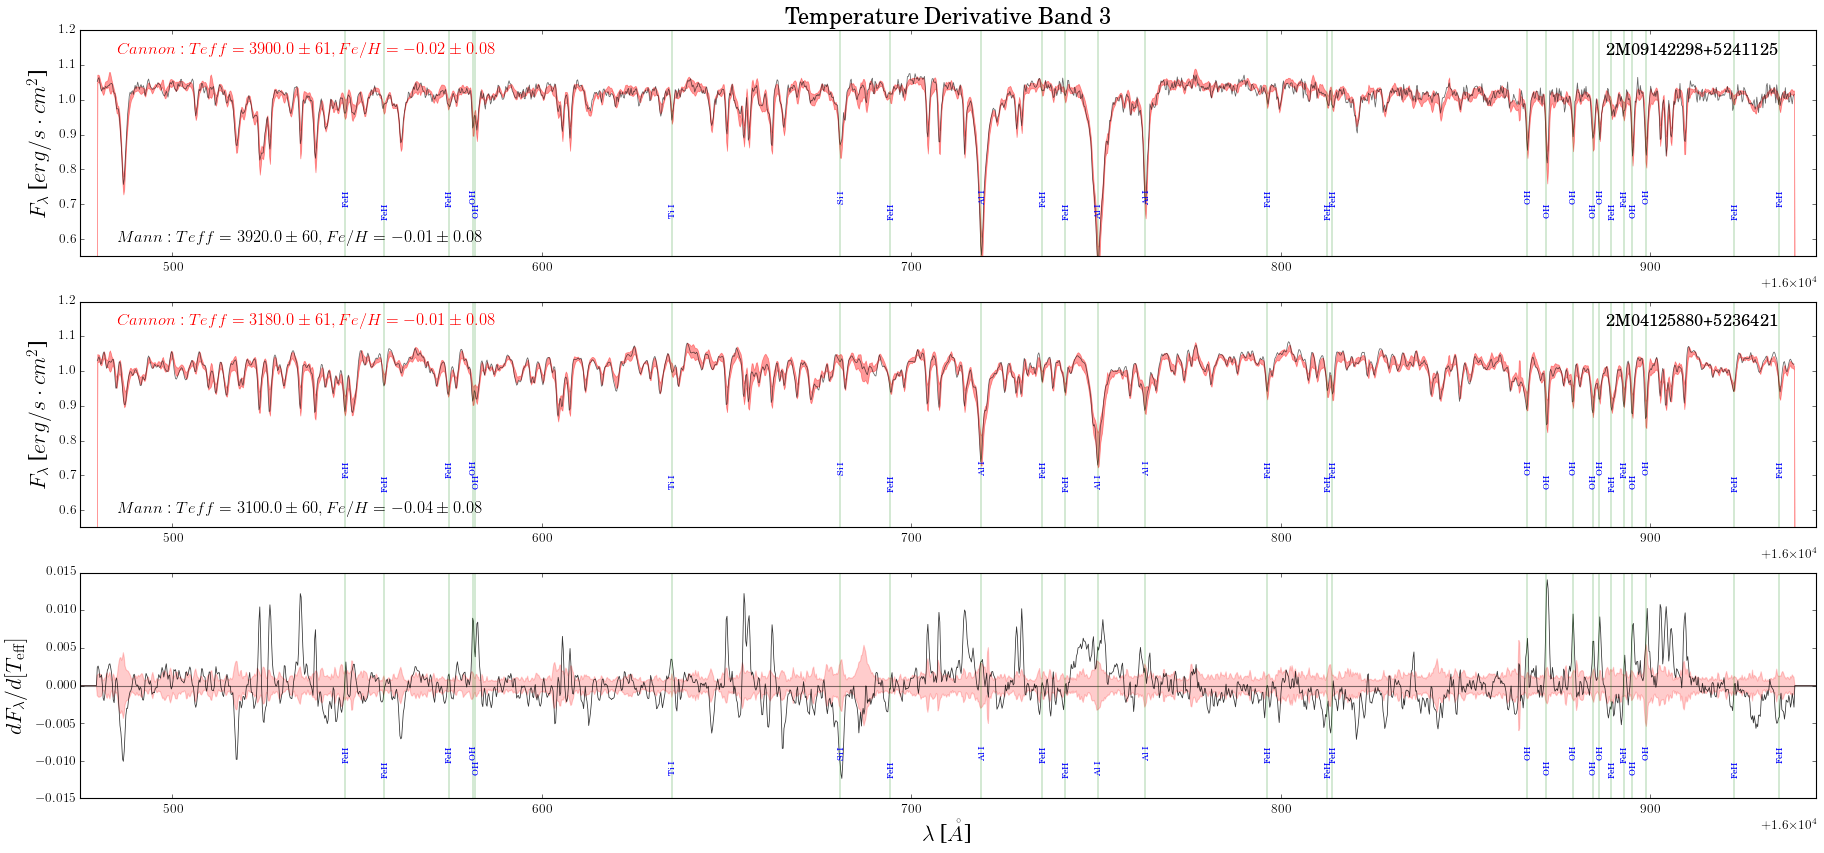

In [63]:
i = 2 #band number
tr_label_unc = [60, .08]
te_label_unc = [61, .08]
demo_specs = ['2M09142298+5241125', '2M04125880+5236421']
ind = [np.where(np.array(ds.tr_ID) == name)[0][0] for name in demo_specs]

k = 3 #label vector index
wave = ds.wl
flux = md.coeffs.T[k]
yrange = [.55,1.2]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28,12), facecolor='w')

cannon_lbl1 = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tst_labels[ind[0]][0],-1), te_label_unc[0], round(tst_labels[ind[0]][1],2), te_label_unc[1]) 
ax1.text(bands[i][0]+10, yrange[1]-.08, cannon_lbl1, color='r', fontsize=15, va='bottom', ha='left')
ax1.text(bands[i][1]-10, yrange[1]-.08, demo_specs[0], color='k', fontsize=15, va='bottom', ha='right')
ref_lbl1 = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tr_label[ind[0]][0],-1), tr_label_unc[0], round(tr_label[ind[0]][1],2), tr_label_unc[1]) 
ax1.text(bands[i][0]+10, yrange[0]+.08, ref_lbl1, color='k', fontsize=15, va='top', ha='left')

#replace zeros with nans in data flux
train_flux1 = ds.tr_flux[ind[0]][pbands[i]]
train_flux1[train_flux1 == 0] = np.nan

ax1.plot(ds.wl[pbands[i]], train_flux1, color='k', alpha=.6, linewidth=.7)
# ax1.plot(ds.wl[pbands[i]], synth[ind[0]][pbands[i]], color='r', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl[pbands[i]], synth[ind[0]][pbands[i]] - md.scatters[pbands[i]], synth[ind[0]][pbands[i]] + md.scatters[pbands[i]], \
                 color='r', alpha=.4, linewidth=.7)

ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=20)
ax1.set_xlim(bands[i])
ax1.set_ylim(yrange)

cannon_lbl2 = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tst_labels[ind[1]][0],-1), te_label_unc[0], round(tst_labels[ind[1]][1],2), te_label_unc[1]) 
ax2.text(bands[i][0]+10, yrange[1]-.08, cannon_lbl2, color='r', fontsize=15, va='bottom', ha='left')
ax2.text(bands[i][1]-10, yrange[1]-.08, demo_specs[1], color='k', fontsize=15, va='bottom', ha='right')
ref_lbl2 = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tr_label[ind[1]][0],-1), tr_label_unc[0], round(tr_label[ind[1]][1],2), tr_label_unc[1]) 
ax2.text(bands[i][0]+10, yrange[0]+.08, ref_lbl2, color='k', fontsize=15, va='top', ha='left')

#replace zeros with nans in data flux
train_flux2 = ds.tr_flux[ind[1]][pbands[i]]
train_flux2[train_flux2 == 0] = np.nan

ax2.plot(ds.wl[pbands[i]], train_flux2, color='k', alpha=.6, linewidth=.7)
# ax2.plot(ds.wl[pbands[i]], synth[ind[0]][pbands[i]], color='r', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl[pbands[i]], synth[ind[1]][pbands[i]] - md.scatters[pbands[i]], synth[ind[1]][pbands[i]] + md.scatters[pbands[i]], \
                 color='r', alpha=.4, linewidth=.7)

ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=20)
ax2.set_xlim(bands[i])
ax2.set_ylim(yrange)

ax3.plot(ds.wl[pbands[i]], md.coeffs.T[k][pbands[i]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[i])
ax3.set_ylim(-.015,.015)

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

count = 0
for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
#         ypos = ds.tr_flux[i][index]
        count += 1
        a1, a2 = .02, .001
        if (count % 2 == 1): a1, a2 = -a1, -a2

        if (feature >= bands[i][0]) & (feature <= bands[i][1]):
            ax1.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax1.text(feature, .7+a1, lines, rotation=90, ha='center', color='b', fontsize=8)
       
            ax2.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax2.text(feature, .7+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

            ax3.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax3.text(feature, -.01+a2, lines, rotation=90, ha='center', color='b', fontsize=8)

# for line in teff_unid_lines:
    
#     if (line >= bands[i][0]) & (line <= bands[i][1]):
#         ax1.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
#         ax2.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
#         ax3.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
        
ax1.set_title('Temperature Derivative Band '+str(i+1), fontsize=20)
plt.savefig('results/demo_derivatives_teff'+str(i+1)+'.png')
plt.show()
plt.close()

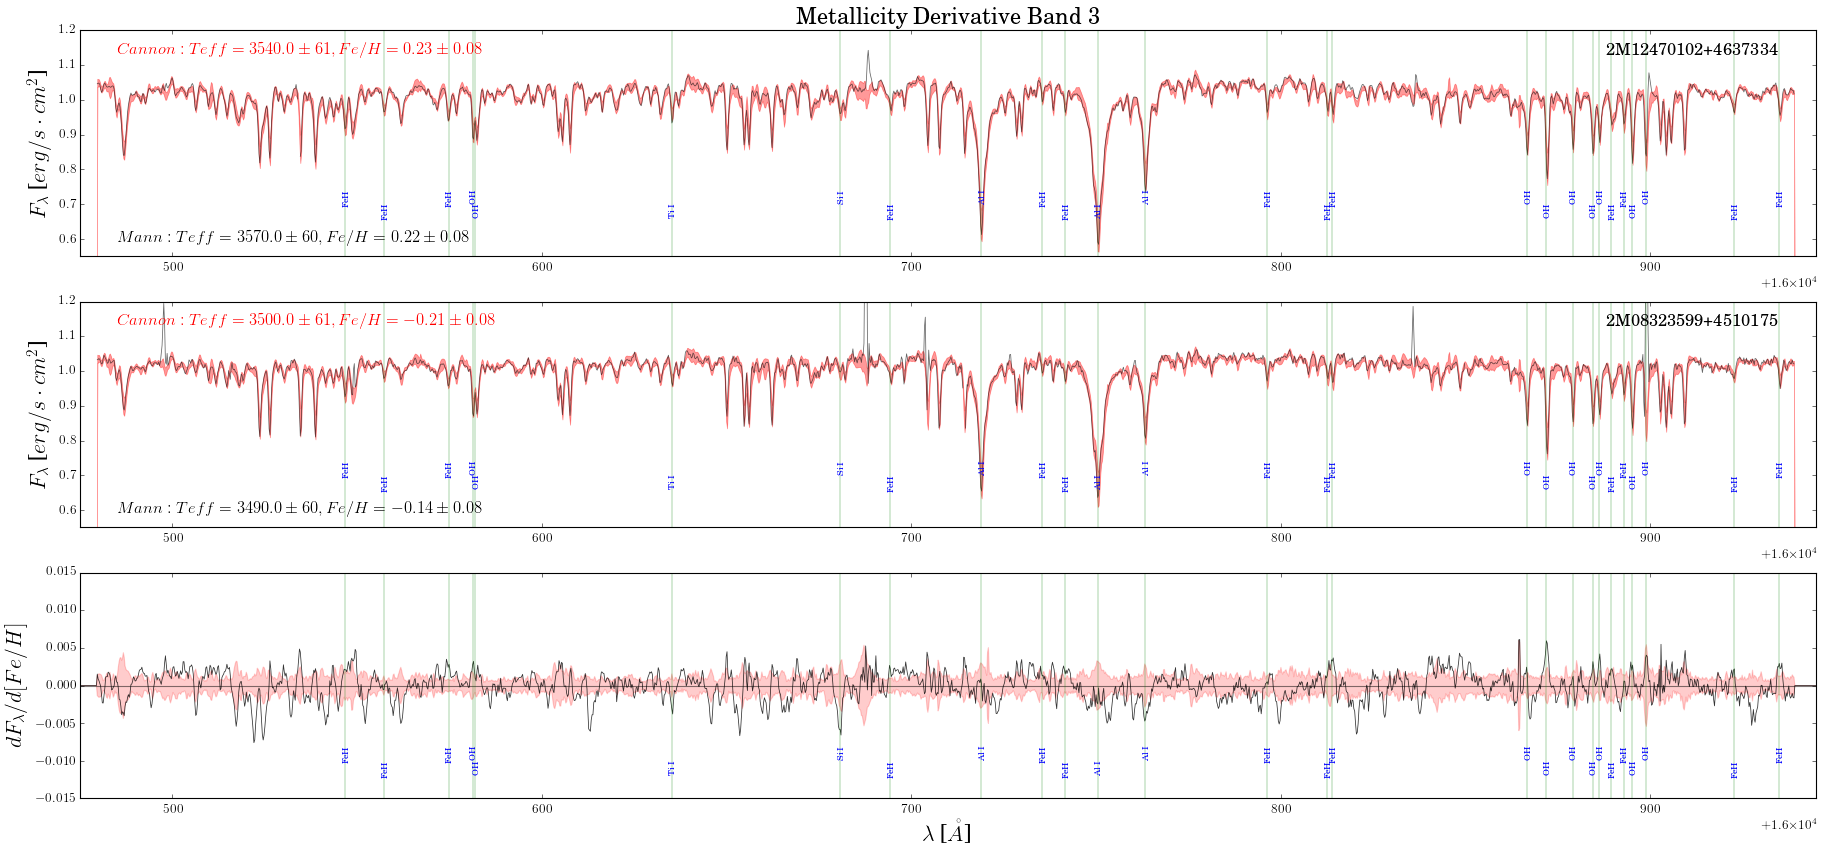

In [61]:
i = 2 #band number
tr_label_unc = [60, .08]
te_label_unc = [61, .08]
demo_specs = ['2M12470102+4637334', '2M08323599+4510175']
ind = [np.where(np.array(ds.tr_ID) == name)[0][0] for name in demo_specs]

k = 4 #label vector index
wave = ds.wl
flux = md.coeffs.T[k]
yrange = [.55,1.2]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28,12), facecolor='w')

cannon_lbl1 = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tst_labels[ind[0]][0],-1), te_label_unc[0], round(tst_labels[ind[0]][1],2), te_label_unc[1]) 
ax1.text(bands[i][0]+10, yrange[1]-.08, cannon_lbl1, color='r', fontsize=15, va='bottom', ha='left')
ax1.text(bands[i][1]-10, yrange[1]-.08, demo_specs[0], color='k', fontsize=15, va='bottom', ha='right')
ref_lbl1 = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tr_label[ind[0]][0],-1), tr_label_unc[0], round(tr_label[ind[0]][1],2), tr_label_unc[1]) 
ax1.text(bands[i][0]+10, yrange[0]+.08, ref_lbl1, color='k', fontsize=15, va='top', ha='left')

#replace zeros with nans in data flux
train_flux1 = ds.tr_flux[ind[0]][pbands[i]]
train_flux1[train_flux1 == 0] = np.nan

ax1.plot(ds.wl[pbands[i]], train_flux1, color='k', alpha=.6, linewidth=.7)
# ax1.plot(ds.wl[pbands[i]], synth[ind[0]][pbands[i]], color='r', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl[pbands[i]], synth[ind[0]][pbands[i]] - md.scatters[pbands[i]], synth[ind[0]][pbands[i]] + md.scatters[pbands[i]], \
                 color='r', alpha=.4, linewidth=.7)

ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=20)
ax1.set_xlim(bands[i])
ax1.set_ylim(yrange)

cannon_lbl2 = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tst_labels[ind[1]][0],-1), te_label_unc[0], round(tst_labels[ind[1]][1],2), te_label_unc[1]) 
ax2.text(bands[i][0]+10, yrange[1]-.08, cannon_lbl2, color='r', fontsize=15, va='bottom', ha='left')
ax2.text(bands[i][1]-10, yrange[1]-.08, demo_specs[1], color='k', fontsize=15, va='bottom', ha='right')
ref_lbl2 = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(\
    round(tr_label[ind[1]][0],-1), tr_label_unc[0], round(tr_label[ind[1]][1],2), tr_label_unc[1]) 
ax2.text(bands[i][0]+10, yrange[0]+.08, ref_lbl2, color='k', fontsize=15, va='top', ha='left')

#replace zeros with nans in data flux
train_flux2 = ds.tr_flux[ind[1]][pbands[i]]
train_flux2[train_flux2 == 0] = np.nan

ax2.plot(ds.wl[pbands[i]], train_flux2, color='k', alpha=.6, linewidth=.7)
# ax2.plot(ds.wl[pbands[i]], synth[ind[0]][pbands[i]], color='r', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl[pbands[i]], synth[ind[1]][pbands[i]] - md.scatters[pbands[i]], synth[ind[1]][pbands[i]] + md.scatters[pbands[i]], \
                 color='r', alpha=.4, linewidth=.7)

ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=20)
ax2.set_xlim(bands[i])
ax2.set_ylim(yrange)

ax3.plot(ds.wl[pbands[i]], md.coeffs.T[k][pbands[i]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[i])
ax3.set_ylim(-.015,.015)

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

count = 0
for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
#         ypos = ds.tr_flux[i][index]
        count += 1
        a1, a2 = .02, .001
        if (count % 2 == 1): a1, a2 = -a1, -a2

        if (feature >= bands[i][0]) & (feature <= bands[i][1]):
            ax1.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax1.text(feature, .7+a1, lines, rotation=90, ha='center', color='b', fontsize=8)
       
            ax2.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax2.text(feature, .7+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

            ax3.axvline(x=feature, ymin=-2, ymax=2, linewidth=.3, color='g')
            ax3.text(feature, -.01+a2, lines, rotation=90, ha='center', color='b', fontsize=8)

# for line in fe_h_unid_lines:
    
#     if (line >= bands[i][0]) & (line <= bands[i][1]):
#         ax1.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
#         ax2.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
#         ax3.axvline(x=line, ymin=-1, ymax=1, linewidth=.1, color='purple', alpha=.15)
        
ax1.set_title('Metallicity Derivative Band '+str(i+1), fontsize=20)
plt.savefig('results/demo_derivatives_feh'+str(i+1)+'.png')
plt.show()
plt.close()

## 3 bands of derivatives:

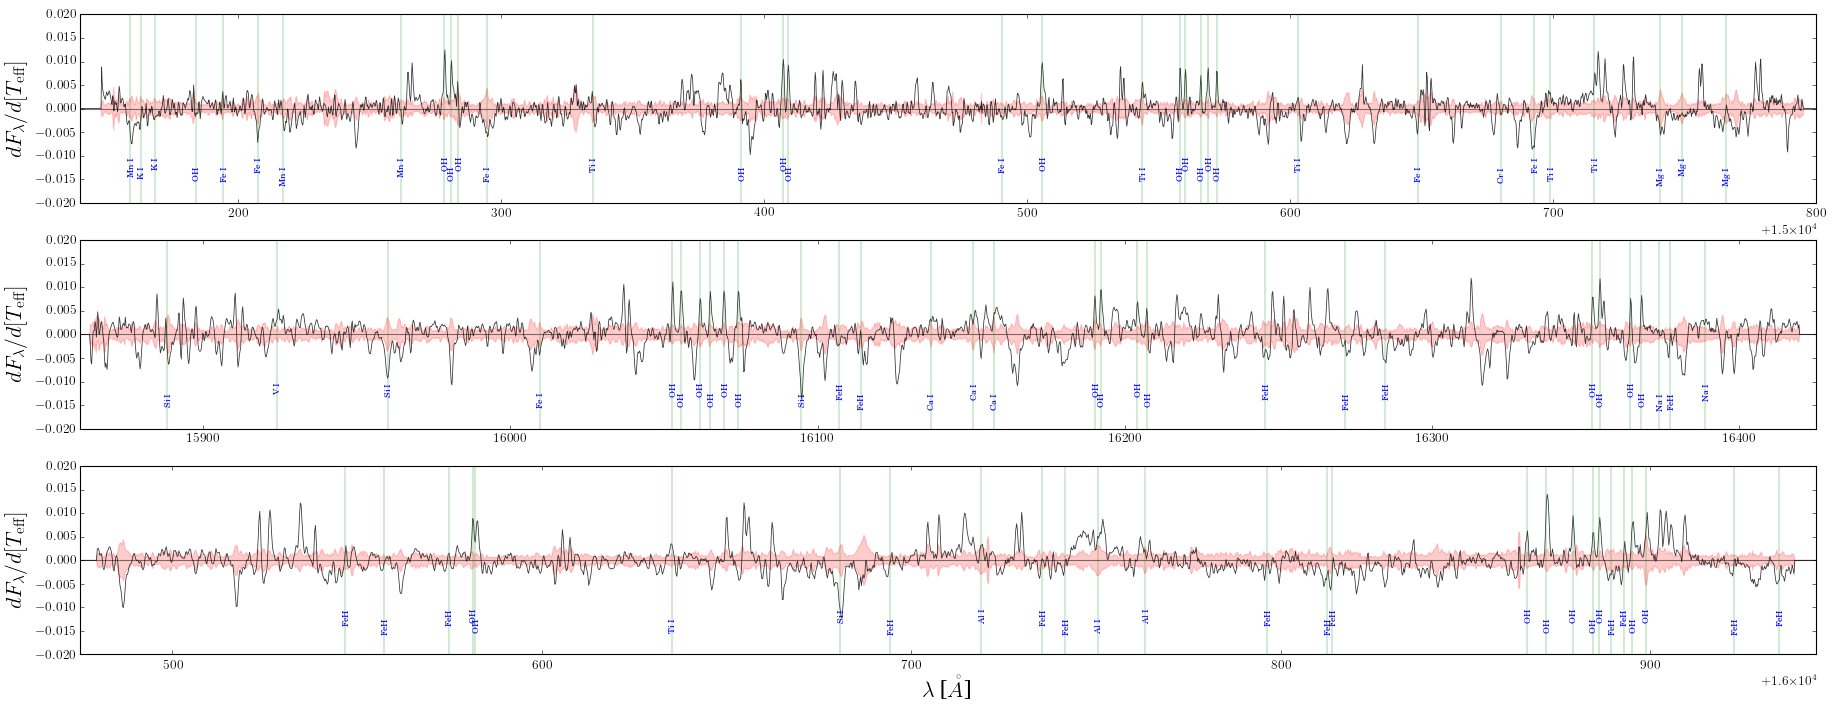

In [55]:
k = 3 # temperature index
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax1.set_xlim(bands[0])

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

count = 0
for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
#         ypos = flux[index]
        count += 1
        a1 = .001
        if (count % 2 == 1): a1 = -a1

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax1.text(feature, -.013+a1, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax2.text(feature, -.013+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax3.text(feature, -.013+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

    
plt.ylim(-.02,.02)
plt.savefig('results/derivative_jackknife_teff.png')
plt.show()

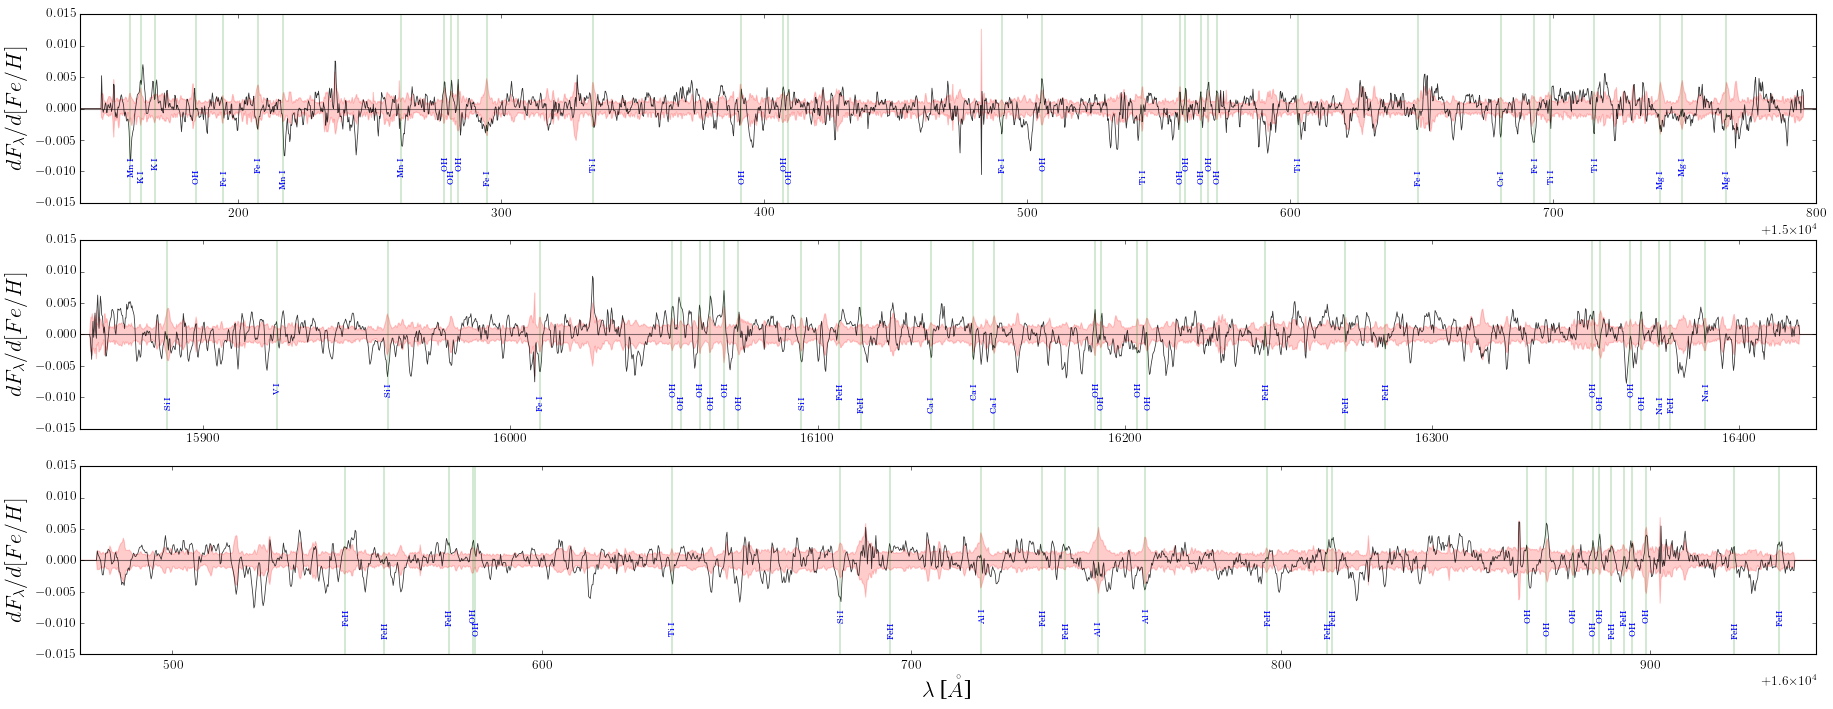

In [59]:
k = 4 # metallicity index
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax1.set_xlim(bands[0])

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_fe_h, jack_err_fe_h, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_fe_h, jack_err_fe_h, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

count = 0
for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
#         ypos = flux[index]
        count += 1
        a1 =  .001
        if (count % 2 == 1): a1 = -a1

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax1.text(feature, -.01+a1, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax2.text(feature, -.01+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=-1, ymax=1, linewidth=.3, color='g')
            ax3.text(feature, -.01+a1, lines, rotation=90, ha='center', color='b', fontsize=8)

plt.ylim(-.015,.015)
plt.savefig('results/derivative_jackknife_feh.png')
plt.show()

## Plot entire training set with Cannon models:

In [80]:
n = 1 #band 1, 2, 3
plotCannonModels(ds, synth, tst_labels, save=True, out='results/Models_Band'+str(n)+'.pdf', base='Mann', \
                 tr_lbl_unc=[71,.08], te_lbl_unc=[71,.08], snr=ds.test_SNR, band=n)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [85]:
for n in [1,2,3]:
    plotCannonModels(ds, synth, tst_labels, save=True, out='results/Models_Band'+str(n)+'.pdf', base='Mann', \
                     tr_lbl_unc=[71,.08], te_lbl_unc=[71,.08], snr=ds.test_SNR, band=n)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [33]:
# Cross validation model
# n = 1 #band 1, 2, 3
# plotCannonModels(ds, synth, tst_labels, save=True, out='results/CRV_Models_Band'+str(n)+'.pdf', base='Mann', \
#                  tr_lbl_unc=[60,.08], te_lbl_unc=[61,.08], snr=ds.test_SNR, band=n)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


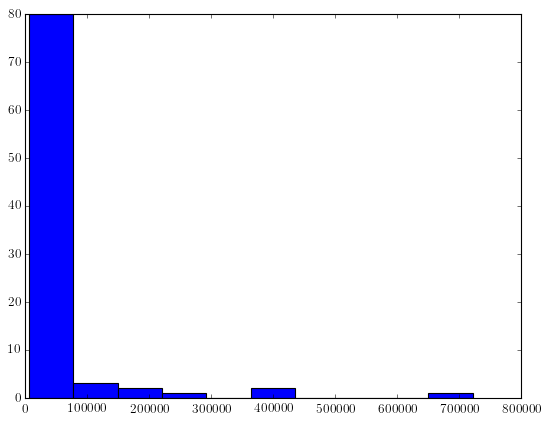

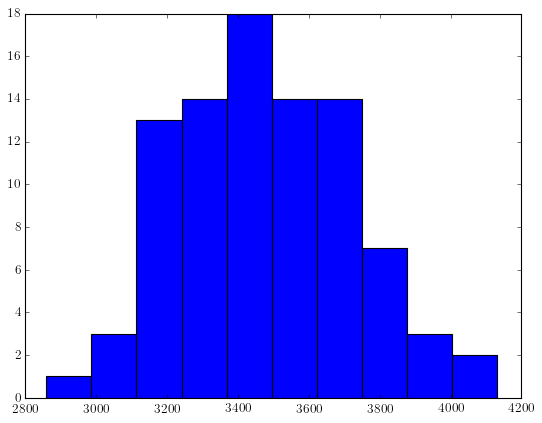

In [86]:
plt.hist(chi)
plt.show()
plt.hist(ds.tr_label.T[0])
plt.show()

In [83]:
def plotCannonModels(ds, te_flux, te_labels, **kwargs):

    bands  = [[15160,15800],[15880,16420],[16500,16935]]
    n      = kwargs.get('band', 1)
    yrange = kwargs.get('yrange', [.6,1.2])
    base   = kwargs.get('base', 'Ref')
    lbl_names = kwargs.get('lbl_names', ['Teff', '[Fe/H]'])
    sigfig = kwargs.get('sigfig', [1 for x in lbl_names])
    snr = kwargs.get('snr', [])
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Models_Band'+str(n)+'.pdf')
    
    nspecs = len(te_flux)
    nparam = len(lbl_names)

    nplots = kwargs.get('nplots', nspecs)
    
    tr_label = ds.tr_label
    tr_label_unc = kwargs.get('tr_lbl_unc')
    te_label = te_labels
    te_label_unc = kwargs.get('te_lbl_unc', [0,0])
    
    wl = ds.wl
    tr_flux = ds.tr_flux
    tr_ivar = ds.tr_ivar
    
    fig, axs = plt.subplots(nplots, 1, figsize=(16,4*nspecs))
    for i, ax in enumerate(fig.axes):

        tr_stdev = [1/math.sqrt(ivar) for ivar in tr_ivar[i]]
        
        tr_flux[i][tr_flux[i] == 0] = np.nan
        
        ax.plot(wl, tr_flux[i], color='k', linewidth=.7)
        ax.plot(wl, te_flux[i], color='r', linewidth=.7)
#         ax.fill_between(wl, te_flux[i] - md.scatters[i], te_flux[i] + md.scatters[i], color='r', linewidth=.7, alpha=.7)
        
        par_str1 = [r'${} = {} \pm {}$'.format(lbl_names[k], round(te_label[i][k],sigfig[k]), te_label_unc[k]) for k in range(nparam)]
        can_lbl  = r'$Cannon: $ {}'.format(', '.join(par_str1))
        ax.text(bands[n-1][0]+10, yrange[1]-.08, can_lbl, color='r', fontsize=15, va='bottom', ha='left')

        par_str2 = [r'${} = {} \pm {}$'.format(lbl_names[k], round(tr_label[i][k],sigfig[k]), tr_label_unc[k]) for k in range(nparam)]
        ref_lbl  = r'${}: $ {}'.format(base, ', '.join(par_str2))
        ax.text(bands[n-1][0]+10, yrange[0]+.08, ref_lbl, color='k', fontsize=15, va='top', ha='left')
        
        chi_lbl = r'$\chi^{2} = %s$'%(str(int(round(chi[i]))))
        ax.text(bands[n-1][1]-10, yrange[1]-.08, chi_lbl, color='r', fontsize=15, va='bottom', ha='right')
        
        if len(snr) != 0:
            snr_lbl = r'$SNR = {}$'.format(str(round(snr[i],1)))
            ax.text(bands[n-1][1]-10, yrange[0]+.08, snr_lbl, color='k', fontsize=15, va='top', ha='right')
         
        ax.set_title(r'${}$'.format(ds.tr_ID[i]), fontsize=20)
        ax.set_xlim(bands[n-1])
        ax.set_ylim(yrange)
        ax.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=15)
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=15)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()